## PART A: DATA ANALYSIS


### Imports

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('tableau-colorblind10')




### **Initial Analysis of data**


Here we observe that:
- The data has no null values so no need to handle it
- The features are obtained using PCA to protect privacy of data and so they must have been scaled already.
- The only features to be scaled are Time and Amount which are scaled using min-max and standard scalings respectively.
- We also observe that the dataset is heavily imbalanced with about 99.8% of data being Non-fraudulent transactions and hence there is a need to augment the Fraud data.

In [44]:
df=pd.read_csv("creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


- The shape of df is (284807, 31)

- The number of null values is  0

- Getting the datatypes of the df
float64    30
int64       1
Name: count, dtype: int64

- Distribution of target class Class
0    284315
1       492
Name: count, dtype: int64

 No. of Legitimate transactions: 0.1727485630620034 %

 No. of Legitimate transactions: 99.82725143693798 %


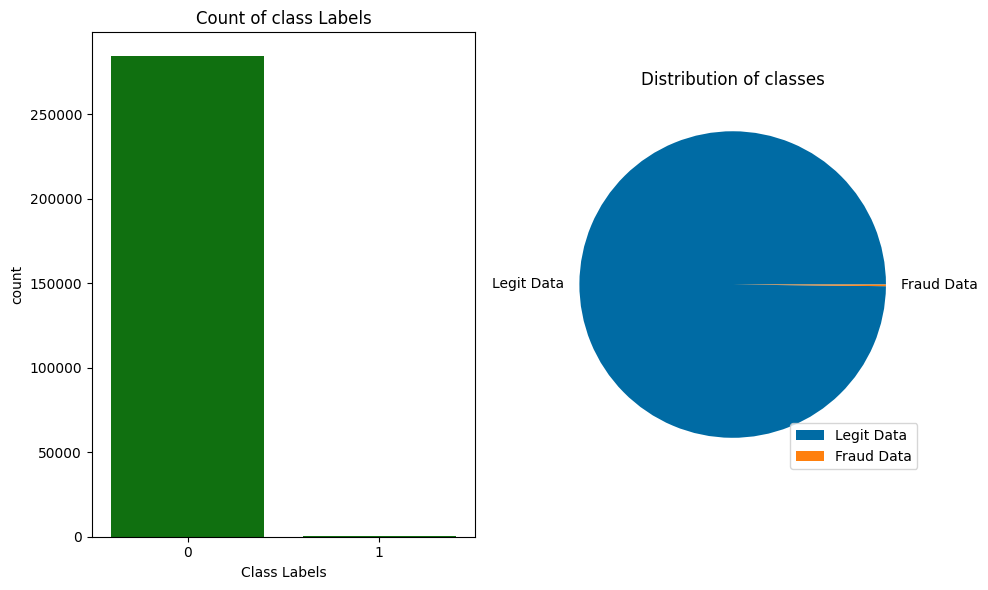

In [45]:
print("- The shape of df is",df.shape)

print("\n- The number of null values is ",df.isnull().sum(axis=0).max())

print("\n- Getting the datatypes of the df")
print(df.dtypes.value_counts())

print("\n- Distribution of target class",df["Class"].value_counts())
print(f"\n No. of Legitimate transactions: {(df['Class'].sum()/len(df["Class"]))*100} %")
print(f"\n No. of Legitimate transactions: {(1-df['Class'].sum()/len(df["Class"]))*100} %")

fig,ax=plt.subplots(1,2,figsize=(10,6))
sns.countplot(x='Class', data=df,color='green',ax=ax[0])  #sns returns axes and so we shouldnt assign it to another axis variable but instead pass in an arguement
ax[0].set(title="Count of class Labels", xlabel="Class Labels")  
ax[1].pie([df["Class"].value_counts()[0],df["Class"].value_counts()[1]],labels=["Legit Data","Fraud Data"])
ax[1].set_title("Distribution of classes")
plt.legend(); plt.tight_layout()  # Ensures legend overlap is mitigated
plt.show()



### **Preparation of Datasets**

- Here we first seperate the dataset into train (80%) and test (20%) such that the proportions of class labels are same in boths sets. This is done using the StratifiedKFold function from sklearn library
- The train dataset is further used to get 2 refined datasets, one with only fraud data and other with only legit data. These datasets will be used further for augmentation
- We also confirm the proportions of test and train data from the outputs given below


In [46]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import roc_auc_score,precision_score,f1_score,accuracy_score,confusion_matrix,classification_report,recall_score

# This is a way to split the data into 5 folds such that each has same proportion(ratio) of target classes. Works only for categorial class variables.
# This can be done in manual way too by segregating the classes, splitting them all and combining them back and use test train split
# Here, the dataset is split into 5 parts with same distribution, then one part is considered the test and the rest the training
# This returns an iterator of length 5, each with a tuple of indices for test and train. So the 5 loop is such that one fold gets to be the test set once.

# for oru purpose only one loop is enough
df['Time']=MinMaxScaler().fit_transform(np.array(df['Time']).reshape(-1,1))
df['Amount']=StandardScaler().fit_transform(np.array(df['Amount']).reshape(-1,1))
ssk=StratifiedKFold(n_splits=5,shuffle=True,random_state=19)


X=df.drop(columns='Class')
Y=df['Class']

arr=ssk.split(X,Y)
train_i,test_i=next(arr)

train_df=df.iloc[train_i]
test_df=df.iloc[test_i]
X_train=X.iloc[train_i]
X_test=X.iloc[test_i]
Y_train=Y.iloc[train_i]
Y_test=Y.iloc[test_i]

print("\nPrepared the training and test sets..... and the size of test is  ", len(X_test), " and train is ", len(X_train))

# Dataset with only Fraud transactions excluding the test set
df_fraud=train_df[train_df["Class"]==1]

X_fraud=df_fraud.drop(columns='Class')
Y_fraud=df_fraud['Class']

print("\nPrepared the Fraud only dataset..... and the size is ",len(X_fraud))

# Dataset with only Legit transactions excluding the test set

df_legit=train_df[train_df["Class"]==0]

X_legit=df_legit.drop(columns="Class")
Y_legit=df_legit['Class']

print("\nPrepared the Legit only dataset..... and the size is ",len(X_legit))


original_count=df['Class'].value_counts()
test_count=Y.value_counts()

print(f"\nThe proportion of classes in original dataset is {original_count[0]/original_count[1]*100} and that of test set is {test_count[0]/test_count[1]*100}")






Prepared the training and test sets..... and the size of test is   56962  and train is  227845

Prepared the Fraud only dataset..... and the size is  393

Prepared the Legit only dataset..... and the size is  227452

The proportion of classes in original dataset is 57787.60162601626 and that of test set is 57787.60162601626


### **Function for model training and evaluation**

- Below is a function that takes in train and test data and evaluates the metrics.
- Our aim here will be to get different datasets from augmentation and then pass them into this function to train, keeping the test set same.
- The function calculates the accuracy, precision, recall, F1 score, ROC-AUC score and plots the confusion matrix

--- 
#### **Why Precision, Recall, and F1-Score Matter More than Accuracy**

- **Accuracy is misleading in imbalanced data:**  
  - In fraud detection, fraudulent cases form only a tiny fraction of all transactions.  
  - A model that predicts “non-fraud” for every transaction will still achieve very high accuracy (close to 99%), but it will **completely fail to detect fraud**.  

- **Precision (for the minority class):**  
  - Precision measures the proportion of predicted fraud cases that are actually fraud.  
  - High precision means fewer false alarms, which is important because flagging too many genuine transactions can frustrate customers and waste resources.  

- **Recall (for the minority class):**  
  - Recall measures the proportion of actual fraud cases that the model successfully detects.  
  - High recall is critical in fraud detection because **missing a fraudulent transaction is very costly**.  

- **F1-score:**  
  - The F1-score is the harmonic mean of precision and recall.  
  - It balances the trade-off: a model with high recall but very low precision (or vice versa) is not ideal.  
  - The F1-score ensures the model performs reasonably well on both aspects.  


- Accuracy alone hides the real performance on rare fraud cases.  
- Precision, Recall, and F1-score directly measure the classifier’s ability to handle the **minority class**, which is the real goal in fraud detection.  


In [47]:
acc=[]
pres=[]
recall=[]
f1=[]
auc=[]

def model_evaluation(X_train,Y_train,X_test,Y_test,name: str):

    print("\nTraining and evaluation initiated for ",name," .....\n")
    reg=LogisticRegression().fit(X_train,Y_train)

    Y_pred=reg.predict(X_test)
    Y_probab=reg.predict_proba(X_test)[:,1]

    print("\nAccuracy:",accuracy_score(Y_test,Y_pred))
    acc.append(accuracy_score(Y_test,Y_pred))
    print("\nPrecision:",precision_score(Y_test,Y_pred))
    pres.append(precision_score(Y_test,Y_pred))
    print("\nRecall:",recall_score(Y_test,Y_pred))
    recall.append(recall_score(Y_test,Y_pred))
    print("\nF1 score:",f1_score(Y_test,Y_pred))
    f1.append(f1_score(Y_test,Y_pred))



    print("\nROC AUC Score:",roc_auc_score(Y_test,Y_probab))
    auc.append(roc_auc_score(Y_test,Y_pred))


    sns.heatmap(confusion_matrix(Y_test,Y_pred),annot=True,fmt='d',yticklabels=["Actual Legit","Actual Fraud"],xticklabels=["Predicted Legit"," Predicted Fraud"])
    # fmt ensures the numbers are represented as whole and not in scientific notation
    plt.title("Confusion Matrix "+ name)
    plt.show()
    # print("\n",classification_report(Y_test,Y_pred))





## PART B: DATA AUGMENTATION

- Our goal here is to generate 3 sets of data
- The first set is such that the fraud data is upsampled using SMOTE which makes the data 50% fraud and 50% Legit, doubling the dataset size. Here we pass the dataframe as a whole
- The second set is such that the fraud data is upsampled using KMeans cluster sampling. Here we pass in only the points with minority class and the size doubles here too
- The third set is such that the legit data is undersampled using clustering models which results in smaller dataset that captures all the patterns and nuances from the initial large dataset
---


### **1.SMOTE**

-  The main goal of SMOTE is to generate synthetic samples for the minority class so that the dataset becomes more balanced.  

- **Step 1: Find Nearest Neighbors**  
  - For each minority sample  x_i , SMOTE looks for its  k -nearest neighbors among other minority samples.  

- **Step 2: Pick a Random Neighbor**  
  - From these  k -nearest neighbors, one neighbor $x_{nn}$ is chosen randomly.  

- **Step 3: Create a New Synthetic Sample**  
  - A new sample is generated between $x_i$ and $x_{nn}$ using linear interpolation:  

  $$
  x_{\text{new}} = x_i + \lambda \cdot (x_{nn} - x_i)
  $$

  where  
  - $\lambda \sim U(0,1)$ is a random number between 0 and 1.  
  - This ensures that $x_{\text{new}}$ lies somewhere along the line between the two samples.  

- By repeating this process for many minority samples, SMOTE produces new synthetic points instead of simply duplicating old ones.  



#### Limitations of SMOTE

- It assumes minority samples form a connected region.  
- If the minority data is scattered or noisy, SMOTE may generate unrealistic samples.  
-  In highly overlapping datasets, SMOTE may create points inside the majority class region, confusing the classifier.  
 

---





#### Justification for choice of number of neighbours (k):
- After going through internet articles and literature, it seems that there is no quantitative metric to measure the effectiveness of k since its just interpolation. Cross-validation over different values of k would yield marginal difference. Hence the most common choice of 5 is made here


C:\Users\MUTHU\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(



SMOTE Augmentation is done.....

 The number of fraud samples now is  227452  and that of legit samples is  227452


[]

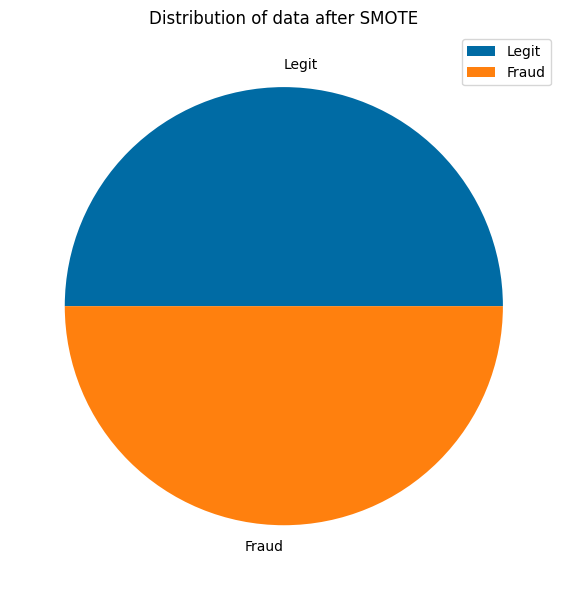

In [48]:
from imblearn.over_sampling import SMOTE
from collections import Counter
smote=SMOTE(k_neighbors=5)
SMOTE_X,SMOTE_Y=smote.fit_resample(X_train,Y_train)

print("\nSMOTE Augmentation is done.....")
print("\n The number of fraud samples now is ", list(Counter(SMOTE_Y).values())[0], " and that of legit samples is ", list(Counter(SMOTE_Y).values())[1])
plt.figure(figsize=(12,6))
plt.pie([list(Counter(SMOTE_Y).values())[0],list(Counter(SMOTE_Y).values())[0]],labels=["Legit","Fraud"])
plt.title("Distribution of data after SMOTE")
plt.legend()
plt.tight_layout()
plt.plot()


## **Clustering-Based Oversampling (CBO)**

- One problem with naive oversampling methods (like random oversampling or even SMOTE) is that they sometimes create too many synthetic points in one region while ignoring others.  
- This can cause the model to  fail to generalize.  

- **Procedure**
  - First, we cluster the minority class samples into a few groups.  
  - Each cluster represents a sub-group or local structure within the minority class.  
  - Then, when oversampling, we generate new samples within each cluster, instead of oversampling randomly across the whole minority set.  
  - All sub-groups of the minority class are well-represented.  
  - It avoids generating synthetic samples in areas where there is no real data (which often happens with global oversampling).  

1. Apply a clustering algorithm (We will use **K-Means**) on the minority class samples only.  
2. Decide the number of clusters `k`. This can be done intuitively or more systematically using the Elbow Method, where we look at the within-cluster sum of squares (WCSS) vs. number of clusters.  
3. After clustering, we oversample each cluster proportionally until the minority class is balanced with the majority.  
4. Finally, we combine the oversampled minority data with the majority data to form a new, balanced dataset.  
5. **Sampling here, basically means duplication of data such that the final dataset has same distribution across clusters as that of the initial dataset**


- By doing this, the classifier will learn all the different sub-groups of fraudulent transactions more effectively.  
- This should reduce bias towards majority regions and improve Recall and F1-score for the minority class.


---


### **Helper functions to determine the cluster count of KMeans**

- Inorder to obtain the correct number of clusters, the knee method of inertia analysis is used where the knee point is observed and chosen as the optimal clustering count

In [49]:
from tqdm import tqdm
from sklearn.cluster import KMeans



def optimal_k(X,maxim=50): # The syntax is that parameter without a default is followed by parameter with a default
    inertia=[]
    for i in tqdm(range(2,maxim+1)):
        kmm=KMeans(n_clusters=i).fit(X)
        # labels=kmm.labels_  Gives an 1D array of same length as input data, with values from 0-n_clusters-1, mapping each point to a cluster which are named by these numbers
        # Silhoutte score measures distance of all points with every other points and is O(N^2) and is very very slow
        inertia.append(kmm.inertia_)
    
    plt.plot(list(range(2,maxim+1)),inertia)
    plt.title("Elbow analysis to find optimal cluster")
    plt.xlabel("No. of clusters")
    plt.ylabel("Inertia")
    plt.show()


    

#### **Model selection for upsampling**

100%|██████████| 49/49 [00:00<00:00, 69.91it/s] 


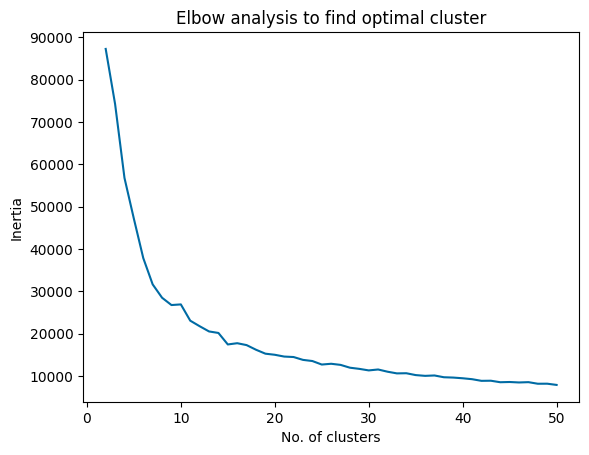

In [50]:
optimal_k(X_fraud)



- The knee point is not very obvious yet we see that it lies somewhere around 10-20. Hence 15 is chosen to be the number of clusters for Upsampling K_Means on Fraud Data

In [51]:
kmm_up=KMeans(n_clusters=15).fit(X_fraud)
print("\nKmeans model over Fraud transaction data is trained.....")


Kmeans model over Fraud transaction data is trained.....


#### **Upsampling using K-Means**


 CBO Augmentation is done.....

 The number of fraud samples now is  284315  and that of legit samples is  227545


[]

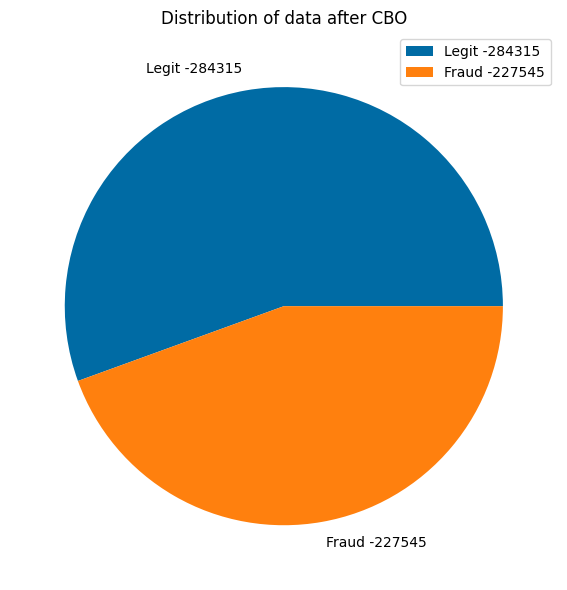

In [52]:
from sklearn.utils import resample

n_needed=len(df_legit)-len(df_fraud)
clusters=kmm_up.labels_

cluster_count=Counter(clusters)
proportion=[]
for i in range(0,15):
    proportion.append(int(cluster_count[i]/len(clusters)*n_needed)) # Now proportion is a array of length 15 with each element corresponding to number of samples to be sampled from a particular cluster

upsamples=[]
for i,prop in enumerate(proportion):
    cluster_pts=X_fraud[clusters==i] # this gets all the points belonging to cluster i
    new_pts=resample(cluster_pts,replace=True,n_samples=prop)
    upsamples.append(new_pts)
    
upsamples=np.vstack(upsamples)

upsamples=np.hstack((upsamples,np.ones_like(upsamples[:,0].reshape(-1,1))))
upsamples=np.vstack((df.values,upsamples))

upsampled_df=pd.DataFrame(upsamples,columns=df.columns)
upsampled_X=upsampled_df.drop(columns="Class")
upsampled_Y=upsampled_df["Class"]

print("\n CBO Augmentation is done.....")
print("\n The number of fraud samples now is ", list(Counter(upsampled_Y).values())[0], " and that of legit samples is ", list(Counter(upsampled_Y).values())[1])
plt.figure(figsize=(12,6))
plt.pie([list(Counter(upsampled_Y).values())[0],list(Counter(upsampled_Y).values())[1]],labels=[f"Legit -{Counter(upsampled_Y)[0]}",f"Fraud -{Counter(upsampled_Y)[1]}"])
plt.title("Distribution of data after CBO")
plt.legend()
plt.tight_layout()
plt.plot()




- Slight imbalance occurs as we truncate the proportions from float to int which is necessary to get the correct count of data for augmentation

## **Clustering Based Undersampling**

### **Training the optimal KMeans model over the Legit data**

- The Legit data is significantly larger in size, and hence undersampling it helps balance the dataset while avoiding excessive oversampling of Fraud data.  
- A KMeans clustering model is trained on the Legit data, which partitions it into multiple clusters.  
- The proportion of data from each cluster is computed, and samples are drawn accordingly to preserve this distribution.  
- This ensures that the undersampled set captures the diversity of different clusters, maintaining a representative spread of Legit data.  
---

- Here the graph doesn't have a distinct knee point but careful observation suggests that it lies in the 20-30 range and so 25 is chosen as the optimal count and model is trained.

100%|██████████| 49/49 [01:58<00:00,  2.42s/it]


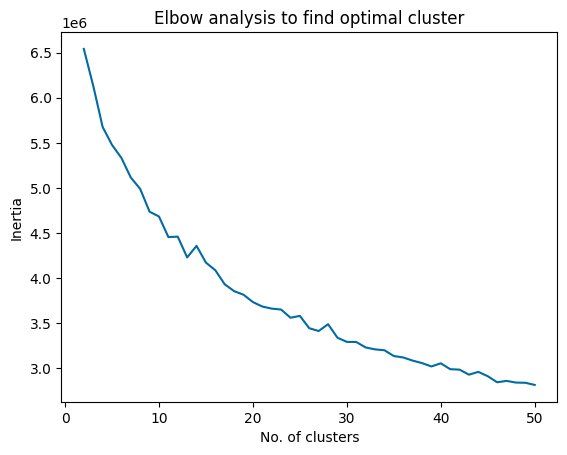


Kmeans model over Legit transaction data is trained.....


In [53]:
optimal_k(X_legit)
kmm=KMeans(n_clusters=25).fit(X_legit)
print("\nKmeans model over Legit transaction data is trained.....")


### **Undersampling**

- Here, The total number of samples of legit is chosen such that the it becomes 60% of the total data while the rest 40% is the original fraud transaction data. 
- The rationale is that this slight increased ratio will convey the model, the info that Fraud transactions are less likely to occur

The Legit transaction data is undersampled and the size is 577

 The undersampled Legit data is ready.....

 CBU Augmentation is done.....

 The number of fraud samples now is  393  and that of legit samples is  577


[]

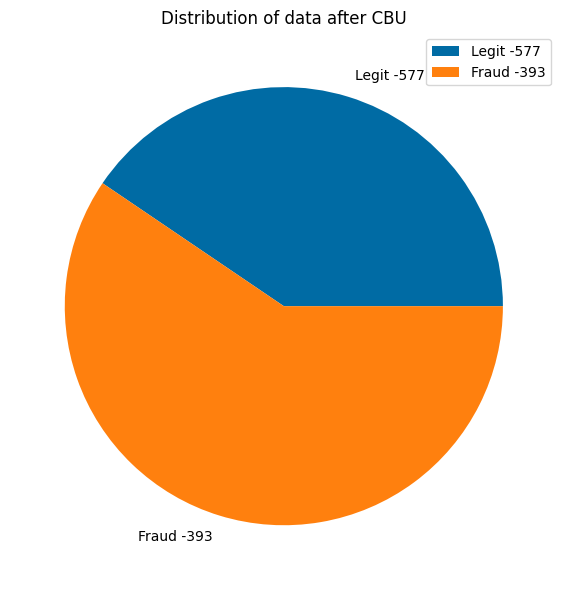

In [54]:


total_size=int(len(X_fraud)/0.4)
undersample_size= total_size-len(X_fraud)

labels=kmm.labels_
cluster_count=Counter(labels)

undersampled_X_legit=[]

for cluster,count in cluster_count.items():

    n_samples=int(count/len(labels)*undersample_size)
    indices=np.where(labels==cluster)[0]
    
    undersampled_indices=np.random.choice(indices,size=n_samples,replace=False)

    undersampled_X_legit.extend(X_legit.values[undersampled_indices]) # X_legit.values to convert it to np array

undersampled_X_legit=np.array(undersampled_X_legit)
print("The Legit transaction data is undersampled and the size is",len(undersampled_X_legit))

undersampled_legit_df=np.hstack((undersampled_X_legit,np.zeros_like(undersampled_X_legit[:,0].reshape(-1,1))))
undersampled_legit_df=pd.DataFrame(undersampled_legit_df,columns=df.columns)

undersampled_df=pd.concat([df_fraud,undersampled_legit_df],ignore_index=True)

print("\n The undersampled Legit data is ready.....")

undersampled_X=undersampled_df.drop(columns="Class")
undersampled_Y=undersampled_df["Class"]




print("\n CBU Augmentation is done.....")
print("\n The number of fraud samples now is ", list(Counter(undersampled_Y).values())[0], " and that of legit samples is ", list(Counter(undersampled_Y).values())[1])
plt.figure(figsize=(12,6))
plt.pie([list(Counter(undersampled_Y).values())[0],list(Counter(undersampled_Y).values())[1]],labels=[f"Legit -{Counter(undersampled_Y)[0]}",f"Fraud -{Counter(undersampled_Y)[1]}"])
plt.title("Distribution of data after CBU")
plt.legend()
plt.tight_layout()
plt.plot()


## PART C: Evaluation

### **1.Evaluation over raw imbalanced data**


Training and evaluation initiated for  Raw imbalanced data  .....


Accuracy: 0.9990871107053826

Precision: 0.9122807017543859

Recall: 0.5252525252525253

F1 score: 0.6666666666666666

ROC AUC Score: 0.9564288578058515


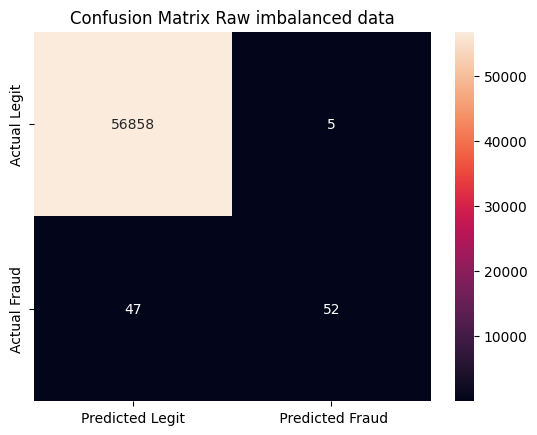

In [55]:
model_evaluation(X_train,Y_train,X_test,Y_test,"Raw imbalanced data")
    


### **2. Evaluation over oversampled data using SMOTE**


Training and evaluation initiated for  SMOTE Oversampling  .....


Accuracy: 0.9751062111583161

Precision: 0.0588628762541806

Recall: 0.8888888888888888

F1 score: 0.11041405269761606

ROC AUC Score: 0.9535111592864437


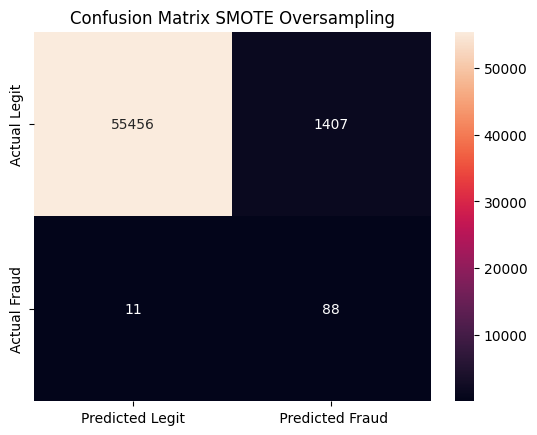

In [56]:
model_evaluation(SMOTE_X,SMOTE_Y,X_test,Y_test,"SMOTE Oversampling")


### **3. CBO**


Training and evaluation initiated for  CBO  .....


Accuracy: 0.9819879919946631

Precision: 0.07901907356948229

Recall: 0.8787878787878788

F1 score: 0.145

ROC AUC Score: 0.9588221699612235


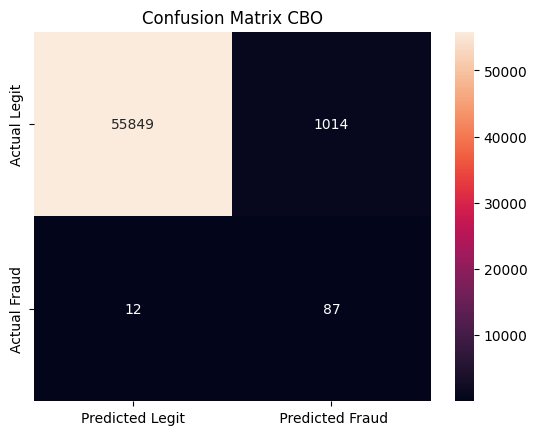

In [57]:
model_evaluation(upsampled_X,upsampled_Y,X_test,Y_test,"CBO")


### **4.CBU**


Training and evaluation initiated for  CBU  .....


Accuracy: 0.9804431024191567

Precision: 0.07317073170731707

Recall: 0.8787878787878788

F1 score: 0.13509316770186336

ROC AUC Score: 0.9562526412499153


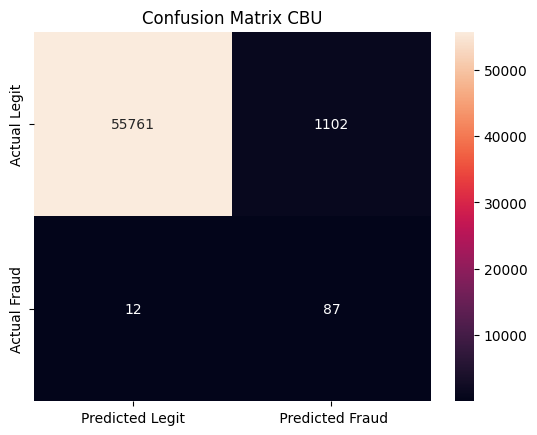

In [58]:
model_evaluation(undersampled_X,undersampled_Y,X_test,Y_test,"CBU")


    Model     Score     Metric
0     Raw  0.999087   Accuracy
1   SMOTE  0.975106   Accuracy
2     CBO  0.981988   Accuracy
3     CBU  0.980443   Accuracy
4     Raw  0.912281  Precision
5   SMOTE  0.058863  Precision
6     CBO  0.079019  Precision
7     CBU  0.073171  Precision
8     Raw  0.525253     Recall
9   SMOTE  0.888889     Recall
10    CBO  0.878788     Recall
11    CBU  0.878788     Recall
12    Raw  0.666667         F1
13  SMOTE  0.110414         F1
14    CBO  0.145000         F1
15    CBU  0.135093         F1
16    Raw  0.762582    ROC-AUC
17  SMOTE  0.932073    ROC-AUC
18    CBO  0.930478    ROC-AUC
19    CBU  0.929704    ROC-AUC


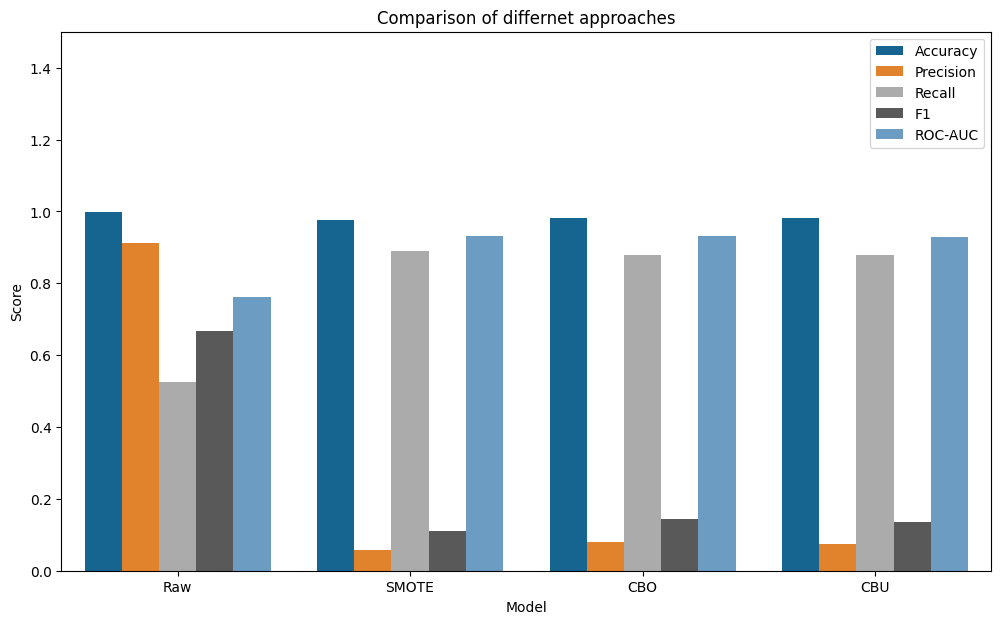

In [59]:
model=["Raw", "SMOTE", "CBO","CBU"]
metric=["Accuracy","Accuracy","Accuracy","Accuracy","Precision","Precision","Precision","Precision","Recall","Recall","Recall","Recall","F1","F1","F1","F1","ROC-AUC","ROC-AUC","ROC-AUC","ROC-AUC"]
summary=pd.DataFrame({"Model":model*5, "Score":acc+pres+recall+f1+auc,"Metric":metric})
print(summary)


plt.figure(figsize=(12,7))
sns.barplot(x="Model",y="Score",data=summary,hue="Metric",)
plt.title("Comparison of differnet approaches")
plt.ylim(0,1.5)
plt.legend()
plt.show()

## **Conclusion**


We experimented with four different training strategies on the classic fraud detection dataset: **Raw Data (no resampling), SMOTE (Naive Oversampling), CBO (Clustering-Based Oversampling), and CBU (Clustering-Based Undersampling)**. Below is a detailed analysis of their benefits, drawbacks, and performance.

---

#### 1. Raw Data (Imbalanced Dataset)  
- **Benefits:** Extremely high accuracy (99.9%) because the model mostly predicts transactions as legitimate.  
- **Drawbacks:** The model predicted **half the fraud transactions as legitimate**, leading to a recall of only 52%. While precision was high (91%), it came at the cost of **missing actual fraud cases**, which is unacceptable in practice.  
- **Conclusion:** Raw data is misleading — accuracy looks good, but fraud detection is weak.  

---

#### 2. SMOTE (Synthetic Minority Oversampling Technique)  
- **Benefits:** Recall shot up to 88% and ROC-AUC improved to 93%, meaning the model became much better at catching fraud.  
- **Drawbacks:** Precision collapsed to just 5.8%, leading to **over 1400 legitimate transactions misclassified as fraud**. This happened because SMOTE **creates synthetic points between minority samples, including in noisy or overlapping regions**. The model then “hallucinates” fraud where there is none, flooding the system with false positives.  
- **Conclusion:** While SMOTE improves recall, it sacrifices practicality — too many false alarms make the model unusable for deployment.  

---

#### 3. CBO (Clustering-Based Oversampling)  
- **Benefits:** Recall (87%) and ROC-AUC (93%) stayed close to SMOTE. However, by oversampling **within minority clusters**, it ensured that new points were representative of real data distributions.  
- **Drawbacks:** Precision improved slightly over SMOTE (7.9% vs. 5.8%), and the number of legitimate transactions wrongly flagged as fraud dropped to around **1000 (vs. 1400 in SMOTE)**. Still, precision remains relatively low.  
- **Conclusion:** More robust than SMOTE because it avoids generating synthetic points in empty or noisy regions.  

---

#### 4. CBU (Clustering-Based Undersampling)  
- **Benefits:** Recall (87%) and ROC-AUC (93%) stayed strong, while false positives were reduced to around **1000 legitimate cases misclassified as fraud**, again better than SMOTE. Since it undersamples legitimate transactions cluster-wise, it **retains diversity in majority data** while avoiding synthetic noise.  
- **Drawbacks:** Precision (7.3%) is slightly lower than CBO but still much better than SMOTE. Some useful legitimate data is lost due to undersampling.  
- **Conclusion:** A safer and more realistic approach than SMOTE, since it works only with real data and reduces false alarms compared to naive oversampling.  

---

### Why CBO and CBU Outperform SMOTE  
- **SMOTE’s Weakness:** It assumes minority points form a dense, well-defined region. In fraud detection, fraud cases are scattered and noisy. SMOTE generates synthetic fraud points that fall into legitimate regions, **causing a flood of false positives (1400 misclassified legitimate cases)**.  
- **CBO and CBU’s Strength:** By relying on clustering, they respect the natural structure of the data.  
  - CBO generates synthetic fraud samples **only inside minority clusters**, avoiding empty regions.  
  - CBU carefully downsamples legitimate data **without discarding whole clusters**, preserving diversity.  
- As a result, both reduce false positives to ~1000, a **significant improvement over SMOTE**.  

---

### Recommendation  
For fraud detection, **recall and ROC-AUC matter more than raw accuracy** (we prefer to catch fraud, even if it means flagging some extra transactions).  

- **Raw Data:** High accuracy but misses too many frauds.  
- **SMOTE:** Best recall but unusable due to excessive false alarms.  
- **CBO:** Good balance; reduces false alarms significantly compared to SMOTE.  
- **CBU:** Similarly high recall and ROC-AUC, fewer false alarms, and safer since it avoids synthetic data.  

**Final Choice:**  
The company should adopt **Clustering-Based Undersampling (CBU)**.  
It offers high fraud detection capability, avoids noisy synthetic samples, and reduces false alarms compared to SMOTE — making it the most practical solution for real-world deployment.  

